In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as scistat

In [35]:
pd.set_option('display.max_rows', 10)

In [36]:
covidtotals = pd.read_csv('C:\dataClean\Python-Data-Cleaning-Cookbook\Chapter04\data\covidtotals.csv')
covidtotals.set_index('iso_code', inplace=True)
totvars = ['location', 'total_cases', 'total_deaths', 'total_cases_pm', 'total_deaths_pm']
demovars = ['population', 'pop_density', 'median_age', 'gdp_per_capita', 'hosp_beds']

In [37]:
covidtotalsonly = covidtotals.loc[:, totvars]
covidtotalsonly.describe()

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
count,2.100000e+02,210.000000,210.000000,210.000000
mean,2.921614e+04,1770.714286,1355.357943,55.659129
std,1.363978e+05,8705.565857,2625.277497,144.785816
min,0.000000e+00,0.000000,0.000000,0.000000
25%,1.757500e+02,4.000000,92.541500,0.884750
50%,1.242500e+03,25.500000,280.928500,6.154000
75%,1.011700e+04,241.250000,1801.394750,31.777250
max,1.790191e+06,104383.000000,19771.348000,1237.551000


In [38]:
# skewness偏度 kurtosis峰度
covidtotalsonly.quantile(np.arange(0.0, 1.1, 0.1))

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
0.0,0.0,0.0,0.0000,0.0000
0.1,22.9,0.0,17.9986,0.0000
0.2,105.2,2.0,56.2910,0.3752
0.3,302.0,6.7,115.4341,1.7183
0.4,762.0,12.0,213.9734,3.9566
...,...,...,...,...
0.6,2514.6,54.6,543.9562,12.2452
0.7,6959.8,137.2,1071.2442,25.9459
0.8,16847.2,323.2,2206.2982,49.9658
0.9,46513.1,1616.9,3765.1363,138.9045


In [39]:
covidtotalsonly.skew()             # 正值表示右偏，负值表示左偏

total_cases        10.804275
total_deaths        8.929816
total_cases_pm      4.396091
total_deaths_pm     4.674417
dtype: float64

In [40]:
covidtotalsonly.kurtosis()

total_cases        134.979577
total_deaths        95.737841
total_cases_pm      25.242790
total_deaths_pm     27.238232
dtype: float64

In [41]:
# scipy库中的Shapiro-Wilk测试
def testnorm(var, df):
    stat, p = scistat.shapiro(df[var])
    return p
testnorm('total_cases', covidtotalsonly)

3.753789128593843e-29

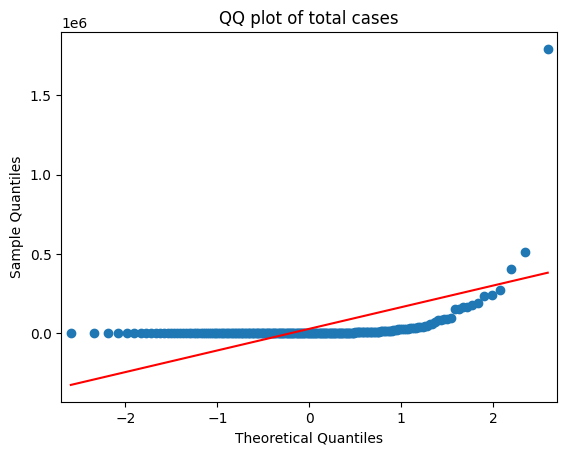

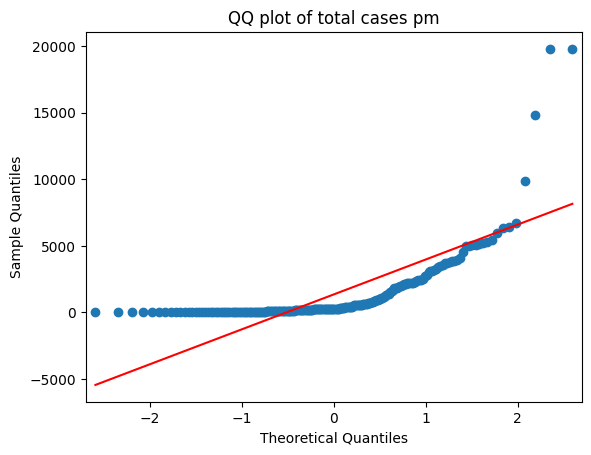

In [42]:
sm.qqplot(covidtotalsonly[['total_cases']].sort_values(['total_cases']), line='s')
plt.title("QQ plot of total cases")
sm.qqplot(covidtotals[['total_cases_pm']].sort_values(['total_cases_pm']), line='s')
plt.title("QQ plot of total cases pm")
plt.show()

如上，直线显示的是正态分布

In [43]:
# 四分位数法界定离群值
thirdq, firstq = covidtotalsonly.total_cases.quantile(0.75), covidtotalsonly.total_cases.quantile(0.25)
interquartilerange = 1.5 * (thirdq-firstq)
outlierhigh, outlierlow = interquartilerange + thirdq, firstq - interquartilerange
print(outlierlow, outlierhigh, sep='<-->')

-14736.125<-->25028.875


In [44]:
def getoutliers():
    dfout = pd.DataFrame(columns=covidtotals.columns, data=None)
    for col in covidtotalsonly.columns[1:]:
        thirdq, firstq = covidtotalsonly.total_cases.quantile(0.75), covidtotalsonly.total_cases.quantile(0.25)
        interquartilerange = 1.5 * (thirdq-firstq)
        outlierhigh, outlierlow = interquartilerange + thirdq, firstq - interquartilerange
        df = covidtotals.loc[(covidtotals[col] > outlierhigh) | (covidtotalsonly[col] < outlierlow)]
        df = df.assign(varname = col, threshlow = outlierlow, threshhigh = outlierhigh)     # 记录哪个列出现问题
        dfout = pd.concat([dfout, df])
    return dfout

In [45]:
outliers = getoutliers()

In [50]:
outliers.varname.value_counts()

total_cases     33
total_deaths     6
Name: varname, dtype: int64

In [47]:
for col in covidtotalsonly.columns[1:]:            # 索引iso_code不算0列
    print(col)

total_cases
total_deaths
total_cases_pm
total_deaths_pm


In [48]:
covidtotalsonly.columns

Index(['location', 'total_cases', 'total_deaths', 'total_cases_pm',
       'total_deaths_pm'],
      dtype='object')

In [49]:
covidtotalsonly

,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm
iso_code,,,,,
AFG,Afghanistan,15205,257,390.589,6.602
ALB,Albania,1137,33,395.093,11.467
DZA,Algeria,9394,653,214.225,14.891
AND,Andorra,764,51,9888.048,660.066
AGO,Angola,86,4,2.617,0.122
...,...,...,...,...,...
VNM,Vietnam,328,0,3.370,0.000
ESH,Western Sahara,23,1,38.505,1.674
YEM,Yemen,323,80,10.829,2.682


In [28]:
outliers.to_excel("views/outlierscases.xlsx")

In [33]:
outliers.loc[outliers.varname=="total_cases", ['location', 'total_cases_pm', 'pop_density', 'gdp_per_capita']].sort_values(['total_cases_pm'], ascending=False)

,location,total_cases_pm,pop_density,gdp_per_capita
QAT,Qatar,19753.146,227.322,116935.600
KWT,Kuwait,6332.420,232.128,65530.537
SGP,Singapore,5962.727,7915.731,85535.383
USA,United States,5408.389,35.608,54225.446
CHL,Chile,5214.841,24.282,22767.037
...,...,...,...,...
PAK,Pakistan,328.033,255.573,5034.708
BGD,Bangladesh,286.315,1265.036,3523.984
IND,India,138.068,450.419,6426.674
IDN,Indonesia,96.785,145.725,11188.744


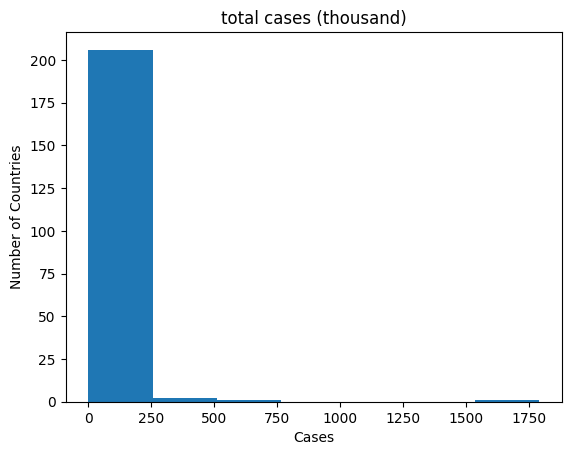

In [51]:
plt.hist(covidtotalsonly['total_cases']/1000, bins=7)
plt.title("total cases (thousand)")
plt.xlabel('Cases')
plt.ylabel('Number of Countries')
plt.show()

In [52]:
covidlogs = covidtotalsonly.copy()

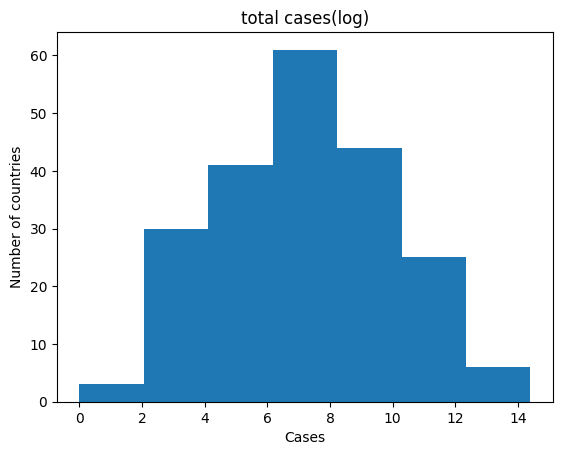

In [54]:
for col in covidtotalsonly.columns[1:]:
    covidlogs[col] = np.log1p(covidlogs[col])
plt.hist(covidlogs['total_cases'], bins=7)
plt.title('total cases(log)')
plt.xlabel('Cases')
plt.ylabel('Number of countries')
plt.show()